In [3]:
# Mercari Price Suggestion Challenge

### 목표.
#1. EDA 기반 파생 피처(feature engineering) 적용
#2. Ridge(선형 모델)과 LightGBM(트리 기반 모델) 비교
#3. 어떤 모델이 더 잘 맞는지 실험으로 증명하기
#4. 테스트파일에 적용해보기.

### 과정.
#1. 데이터 전처리 및 파생 피처 생성
#2. Ridge 모델 학습 → 성능 확인
#3. LightGBM 모델 학습 → 성능 확인
#4. 두 모델 비교 및 해석
#5. 최종 test 예측 + CSV 생성

In [ ]:
#import 및 데이터 불러오기.

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import lightgbm as lgb

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

train_df = pd.read_csv("train.tsv", sep="\t")
test_df = pd.read_csv("test.tsv", sep="\t")

print(train_df.shape)
print(test_df.shape)

(1482535, 8)
(693359, 7)


In [ ]:
# test파일에도 적용하기 위해서는 train에 적용했던 전처리과정을 다시 해야함.

#category_missing과 brand_missing 처리 시, 한쪽은 Unknown을 사용하고 한쪽은 결측 그대로를 처리함.
# Unknown -> 어떤 카테고리인지 모름 missing -> 카테고리가 원래 비어있었다는 사실.

# category_name 결측 처리 
train_df['category_name'] = train_df['category_name'].fillna('Unknown')
test_df['category_name'] = test_df['category_name'].fillna('Unknown')

# category를 " / " 기준으로 split하기.
def split_categories(df):
    split = df['category_name'].str.split('/', expand=True)
    df['cat1'] = split[0].str.lower()
    df['cat2'] = split[1].astype(str).str.lower()
    df['cat3'] = split[2].astype(str).str.lower()
    return df

train_df = split_categories(train_df)
test_df = split_categories(test_df)


# 기본 결측 플래그
train_df['brand_missing'] = train_df['brand_name'].isna().astype(int)
test_df['brand_missing'] = test_df['brand_name'].isna().astype(int)

train_df['category_missing'] = (train_df['category_name'] == 'Unknown').astype(int)
test_df['category_missing'] = (test_df['category_name'] == 'Unknown').astype(int)

# 로그 가격
train_df['log_price'] = np.log1p(train_df['price'])

In [ ]:
train['item_description'] == 'No description yet')

0           True
1          False
2          False
3          False
4          False
           ...  
1482530    False
1482531    False
1482532    False
1482533    False
1482534    False
Name: item_description, Length: 1482535, dtype: bool

In [7]:
import string

def preprocess(df):
    df = df.copy()

    # 브랜드 채우기
    df['brand_filled'] = df['brand_name'].fillna("unknown").astype(str).str.lower()

    # 텍스트 처리
    df['name_filled'] = df['name'].fillna("").astype(str).str.lower()
    df['desc_filled'] = df['item_description'].fillna("").astype(str).str.lower()

    # 글자수 / 단어수
    df['name_len'] = df['name_filled'].str.len()
    df['name_word_count'] = df['name_filled'].str.split().str.len()

    df['desc_len'] = df['desc_filled'].str.len()
    df['desc_word_count'] = df['desc_filled'].str.split().str.len()

    # 설명 없음 여부
    df['no_desc'] = (df['desc_len'] == 0).astype(int)

    # 특수문자 체크
    special = string.punctuation

    df['name_special_count'] = df['name_filled'].apply(lambda x: sum(c in special for c in x))
    df['name_special'] = (df['name_special_count'] > 0).astype(int)

    df['desc_special_count'] = df['desc_filled'].apply(lambda x: sum(c in special for c in x))
    df['desc_special'] = (df['desc_special_count'] > 0).astype(int)

    # 숫자 체크
    df['name_digit_count'] = df['name_filled'].apply(lambda x: sum(c.isdigit() for c in x))
    df['name_digit'] = (df['name_digit_count'] > 0).astype(int)

    df['desc_digit_count'] = df['desc_filled'].apply(lambda x: sum(c.isdigit() for c in x))
    df['desc_digit'] = (df['desc_digit_count'] > 0).astype(int)

    # 가격 제거 흔적 ('rm')
    df['contains_rm'] = df['name_filled'].str.contains(r"\[rm\]", regex=True).astype(int)
    df['desc_rm'] = df['desc_filled'].str.contains(r"\[rm\]", regex=True).astype(int)

    # 카테고리 개수
    df['category_count'] = df['category_name'].str.count('/') + 1

    # 상품명/설명 안에 카테고리 포함 여부
    df['has_category_in_name'] = df.apply(lambda x:
        int(x['cate1'] in x['name_filled'] or x['cate2'] in x['name_filled']), axis=1)

    df['has_category_in_desc'] = df.apply(lambda x:
        int(x['cate1'] in x['desc_filled'] or x['cate2'] in x['desc_filled']), axis=1)

    # 브랜드가 텍스트에 포함되는지
    df['has_brand_in_name'] = df.apply(lambda x:
        int(isinstance(x['brand_filled'], str) and x['brand_filled'] in x['name_filled']), axis=1)

    df['has_brand_in_desc'] = df.apply(lambda x:
        int(isinstance(x['brand_filled'], str) and x['brand_filled'] in x['desc_filled']), axis=1)

    return df

In [8]:
train = preprocess(train_df)
test = preprocess(test_df)

print(train.shape)
print(test.shape)
train.head()

(1482535, 37)
(693359, 35)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cate1,cate2,...,name_digit,desc_digit_count,desc_digit,contains_rm,desc_rm,category_count,has_category_in_name,has_category_in_desc,has_brand_in_name,has_brand_in_desc
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,men,tops,...,0,0,0,0,0,3,0,0,0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers & tablets,...,0,0,0,0,0,3,0,0,1,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops & blouses,...,0,2,1,0,0,3,0,0,0,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home décor,...,0,0,0,0,1,3,0,0,0,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,women,jewelry,...,1,0,0,0,0,3,0,0,0,0


In [9]:
features = [
    'item_condition_id',   # 제품 상태
    'shipping',            # 배송비 지불자

    'brand_filled',        # 자동 보정된 브랜드 (문자 → 라벨 인코딩)
    'cate1',               # 카테고리 대분류
    'cate2',               # 카테고리 중분류
    'cate3',               # 카테고리 소분류

    'name_len',            # 상품명 글자 수
    'name_word_count',     # 상품명 단어 수
    'desc_word_count',     # 설명 단어 수
    'desc_len',            # 설명 글자 수

    'brand_missing',       # 브랜드의 유무
    'category_missing',    # 카테고리의 유무
    'no_desc',             # 제품 설명 존재 여부

    'name_special',        # 이름에 특수기호 존재 여부
    'name_special_count',  # 이름에 특수기호 개수
    'name_digit',          # 이름에 숫자 존재 여부
    'name_digit_count',    # 이름에 숫자 개수

    'contains_rm',         # 이름에 [rm] 포함 여부
    'category_count',      # 카테고리 개수

    'desc_rm',             # 설명에 [rm] 포함 여부
    'desc_special',        # 설명 특수기호 존재 여부
    'desc_special_count',  # 설명 특수기호 개수
    'desc_digit',          # 설명 숫자 존재 여부
    'desc_digit_count',    # 설명 숫자 개수

    'has_category_in_name',  # 이름에 카테고리 포함 여부
    'has_category_in_desc',  # 설명에 카테고리 포함 여부
    'has_brand_in_name',     # 이름에 브랜드 존재 여부
    'has_brand_in_desc',     # 설명에 브랜드 존재 여부
]

#라벨인코딩이 필요한 컬럼(문자형 카테고리)
cat_cols = ['brand_filled', 'cate1', 'cate2', 'cate3']

from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # train + test를 합쳐서 fit → 둘 다 같은 매핑 사용
    all_values = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(all_values)

    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

    label_encoders[col] = le  # 나중에 필요하면 쓸 수 있도록 저장

    # 3) X, y 정의
X = train[features].copy()
y = train['log_price'].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1482535, 28)
y shape: (1482535,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,       # 30%는 검증용
    random_state=42
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)

X_train: (1186028, 28)
X_valid: (296507, 28)


In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score

# 1) 모델 선언
ridge = Ridge(alpha=1.0, random_state=42)

# 2) 학습
ridge.fit(X_train, y_train)

# 3) 검증 데이터 예측
y_pred_ridge = ridge.predict(X_valid)

# 4) 로그 스케일에서의 평가
rmse_ridge_log = root_mean_squared_error(y_valid, y_pred_ridge)
r2_ridge = r2_score(y_valid, y_pred_ridge)

# 5) 실제 가격 기준 RMSE도 한 번 계산
y_valid_price = np.expm1(y_valid)
y_pred_ridge_price = np.expm1(y_pred_ridge)
rmse_ridge_price = root_mean_squared_error(y_valid_price, y_pred_ridge_price)

print("=== Ridge 모델 성능 ===")
print(f"Ridge R² (log price 기준): {r2_ridge:.4f}")
print(f"Ridge RMSE (log price 기준): {rmse_ridge_log:.4f}")
print(f"Ridge RMSE (실제 price 기준): ${rmse_ridge_price:.2f}")

=== Ridge 모델 성능 ===
Ridge R² (log price 기준): 0.1199
Ridge RMSE (log price 기준): 0.7046
Ridge RMSE (실제 price 기준): $39.58


In [13]:
from lightgbm import LGBMRegressor

# 1) 모델 선언
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=500,      # 트리 개수
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
)

# 2) 학습 (검증셋으로 평가도 같이 진행)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
)

# 3) 검증 데이터 예측
y_pred_lgbm = lgbm.predict(X_valid)

# 4) 로그 스케일 평가
rmse_lgbm_log = root_mean_squared_error(y_valid, y_pred_lgbm)
r2_lgbm = r2_score(y_valid, y_pred_lgbm)

# 5) 실제 가격 기준 RMSE
y_pred_lgbm_price = np.expm1(y_pred_lgbm)
rmse_lgbm_price = root_mean_squared_error(y_valid_price, y_pred_lgbm_price)

print("\n=== LightGBM 모델 성능 ===")
print(f"LGBM R² (log price 기준): {r2_lgbm:.4f}")
print(f"LGBM RMSE (log price 기준): {rmse_lgbm_log:.4f}")
print(f"LGBM RMSE (실제 price 기준): ${rmse_lgbm_price:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 27
[LightGBM] [Info] Start training from score 2.978479

=== LightGBM 모델 성능 ===
LGBM R² (log price 기준): 0.4342
LGBM RMSE (log price 기준): 0.5649
LGBM RMSE (실제 price 기준): $34.03


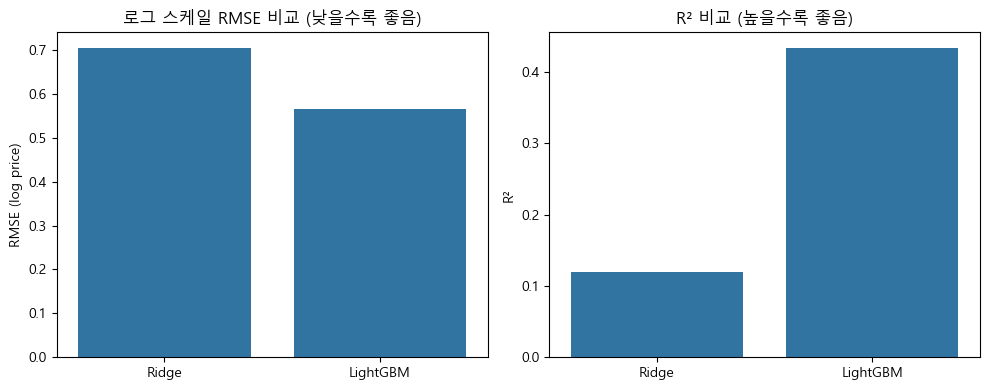

In [14]:
models = ['Ridge', 'LightGBM']
rmse_logs = [rmse_ridge_log, rmse_lgbm_log]
rmse_prices = [rmse_ridge_price, rmse_lgbm_price]
r2_scores = [r2_ridge, r2_lgbm]

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=rmse_logs)
plt.title('로그 스케일 RMSE 비교 (낮을수록 좋음)')
plt.ylabel('RMSE (log price)')

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_scores)
plt.title('R² 비교 (높을수록 좋음)')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

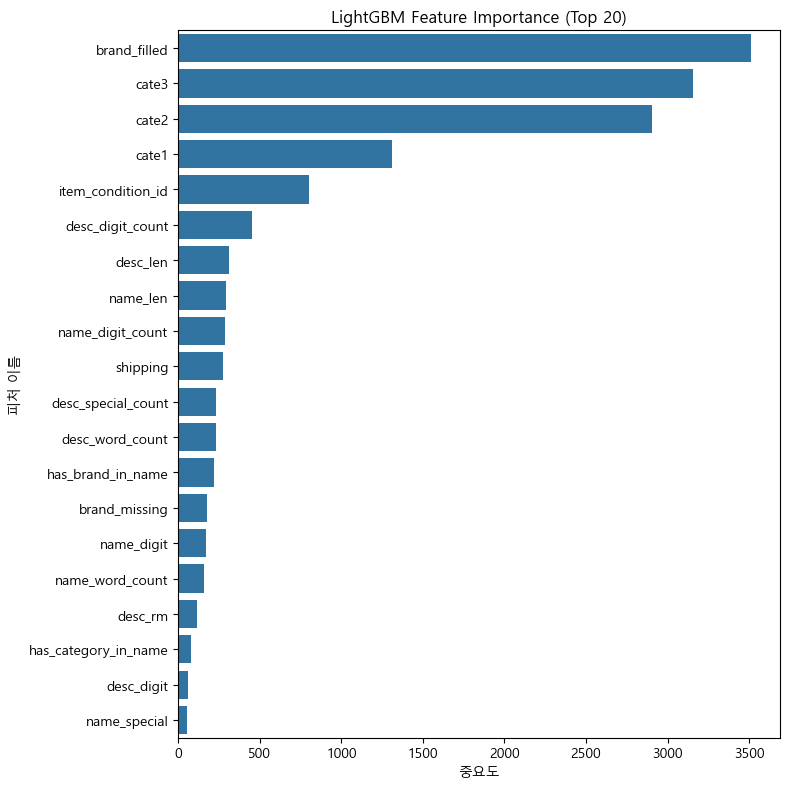

In [ ]:
importances = lgbm.feature_importances_
feat_names = features

# 중요도 순으로 정렬
idx = np.argsort(importances)[::-1]

top_n = 20  # 상위 20개만 보여주기
top_idx = idx[:top_n]

plt.figure(figsize=(8, 8))
sns.barplot(
    x=importances[top_idx],
    y=np.array(feat_names)[top_idx]
)
plt.title('LightGBM Feature Importance (Top 20)')
plt.xlabel('중요도')
plt.ylabel('피처 이름')
plt.tight_layout()
plt.show()






In [16]:
X_test = test[features].copy()

# 1) Ridge 예측
test_log_pred_ridge = ridge.predict(X_test)
test_price_pred_ridge = np.expm1(test_log_pred_ridge)

submission_ridge = pd.DataFrame({
    'test_id': test['test_id'],
    'price': test_price_pred_ridge
})
submission_ridge.to_csv('submission_ridge_advanced.csv', index=False)

# 2) LightGBM 예측
test_log_pred_lgbm = lgbm.predict(X_test)
test_price_pred_lgbm = np.expm1(test_log_pred_lgbm)

submission_lgbm = pd.DataFrame({
    'test_id': test['test_id'],
    'price': test_price_pred_lgbm
})
submission_lgbm.to_csv('submission_lgbm_advanced.csv', index=False)

print("저장 완료:")
print(" - submission_ridge_advanced.csv")
print(" - submission_lgbm_advanced.csv")

저장 완료:
 - submission_ridge_advanced.csv
 - submission_lgbm_advanced.csv
